In [13]:
! pip install --upgrade markupsafe

In [14]:
! pip install -U -q matplotlib scikit-learn scipy

# DATA 607 Assignment 1

## Inferring product demand from sales data

Your cousin Eva owns a gourmet fruit and vegetable store and wants your help optimizing her avocado (or, as she calls them, Evacado) sales.
She gets a shipment of 300 avocados at the beginning of every week, and sells out by the end most weeks.
She doesn't carry over Evacado stock week-to-week. 

Eva wants your help "data science-ing" her sales records from the last two years to better estimate Evacado demand, with an eye to optimizing her weekly order.
Here's a sketch of how you might proceed:

Evacado demand fluctuates week-to-week.
Let's assume it's $N(\mu, \sigma^2)$-distributed.
In this exercise, we develop an approach to estimating $\mu$ and $\sigma$.

Let $x_i$ be the number of Evacados sold in week $i$; this is our dataset.
Note that $x_i\leq 300$.
Let $y_i$ be the true Evacado demand in week $i$. If $x_i \lt 300$, then $y_i=x_i$. If, on the other hand, $x_i=300$, then we don't know what $y_i$ is.

Given initial estimates $m$ and $s$ of $\mu$ and $\sigma$, we can guess at (jargon: **impute**) the true Evacado demand $y_i$ for week $i$.
If $x_i < 300$, set $Y_i=x_i$.
If, on the other hand, $x_i \geq 300$, draw samples from $N(m, s^2)$ until we get one that's $\geq 300$; call it $Y_i$.

Now use the imputed demands $Y_i$ to update your estimates of $\mu$ and $\sigma$:
$$
m' = \operatorname{mean}(Y),\qquad s'=\operatorname{std}(Y)
$$

We've designed a mechanism that takes, as input, a pair of estimates $(m, s)$ and produces, as output, a hopefully improved pair $(m', s')$.
We can iterate this process, hopefully converging on good estimates of $\mu$ and $\sigma$.
Kick the process off by initializing $Y$ to $x$.

**Your task:**
Implement this scheme for estimating $\mu$ and $\sigma$.

- Start by computing vectors `m` and `s` of length `n_iter` (2000) containing your sequence of estimates of $\mu$ and $\sigma$, and plotting them.
(I provided the plotting code below.)

- You should notice that `m` and `s` are noisy.
Smooth them out by averaging.
Specifically, compute vectors `m_bar` and `s_bar` of length `n_iter` whose `i`-th enties are the averages of `m[:i + 1]` and `s[:i + 1]`, respectively.
Plot these, too; again, I provided the plotting code.

- Your final estimates of $\mu$ and $\sigma$ are `m_bar[-1]` and `s_bar[-1]`, respectively.

**Remark:**
The approach followed in this problem is an example of a Monte Carlo Expectation Maximization (MC-EM) algorithm.
EM algorithms are useful for a variety of parameter estimation problems involving censored data.

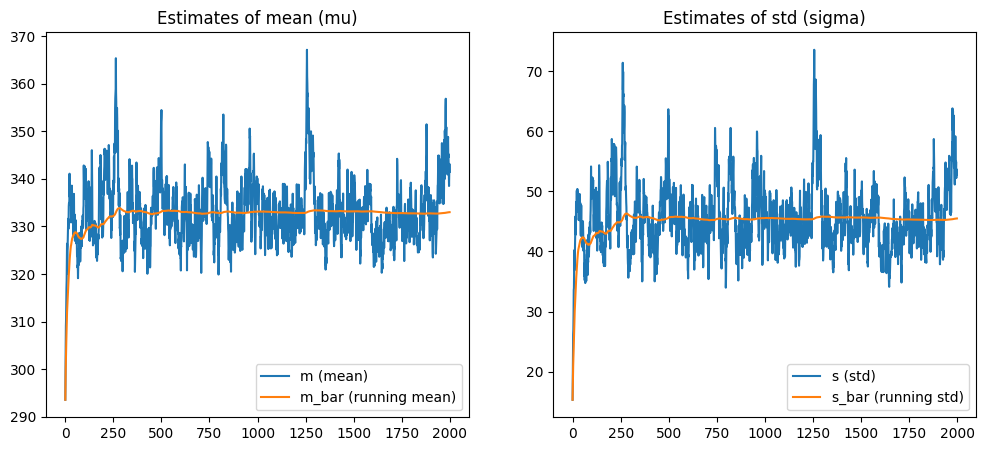

Final estimate of mu: 332.99
Final estimate of sigma: 45.49


In [15]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


k = 300  # weekly Evacado supply
n_iter = 2000
rng = np.random.default_rng(42)

# fmt: off
x = np.array([300, 300, 300, 270, 300, 300, 300, 300, 300, 300, 300, 300, 293,
              300, 300, 300, 300, 300, 291, 300, 300, 300, 300, 300, 214, 246,
              300, 300, 300, 300, 300, 278, 300, 300, 300, 300, 300, 256, 300,
              300, 273, 295, 300, 284, 300, 300, 300, 300, 300, 300, 300, 289,
              300, 300, 300, 279, 300, 300, 272, 300, 300, 300, 283, 278, 300,
              300, 300, 300, 256, 300, 300, 300, 290, 300, 300, 300, 300, 263,
              300, 300, 300, 300, 257, 274, 300, 300, 296, 300, 300, 300, 300,
              300, 300, 300, 300, 232, 300, 300, 265, 300, 296, 300, 300, 300])
# fmt: on


def sample_from_truncated_normal(m, s):
    """Draw len(x) samples from the normal distribution with mean `m` and
    standard deviation `s` conditioned on those samples being >= k."""
    a, b = (k - m) / s, np.inf
    return stats.truncnorm.rvs(a, b, loc=m, scale=s, size=(x == k).sum(), random_state=rng)

# Initialize arrays to store the sequence of estimates
m = np.zeros(n_iter)
s = np.zeros(n_iter)

# Initial imputation: set Y = x
Y = x.copy().astype(float)

# Initial estimates
m[0] = Y.mean()
s[0] = Y.std()

for i in range(1, n_iter):
    # Impute censored values
    Y_imp = Y.copy()
    mask = (x == k)
    if mask.any():
        Y_imp[mask] = sample_from_truncated_normal(m[i-1], s[i-1])
    # Update estimates
    m[i] = Y_imp.mean()
    s[i] = Y_imp.std()
    Y = Y_imp

# Compute running averages
m_bar = np.cumsum(m) / (np.arange(n_iter) + 1)
s_bar = np.cumsum(s) / (np.arange(n_iter) + 1)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(m, label='m (mean)')
plt.plot(m_bar, label='m_bar (running mean)')
plt.legend()
plt.title('Estimates of mean (mu)')

plt.subplot(1, 2, 2)
plt.plot(s, label='s (std)')
plt.plot(s_bar, label='s_bar (running std)')
plt.legend()
plt.title('Estimates of std (sigma)')
plt.show()

print(f"Final estimate of mu: {m_bar[-1]:.2f}")
print(f"Final estimate of sigma: {s_bar[-1]:.2f}")

## Optimizing Eva's avocado order

Suppose Eva buys her avocados for \$1 and sells them (rebranded to Evacados) for \$2.

**Your tasks:**

1. Simulate 10,000 weeks of Evacado demand using your demand model $N(\overline{m}_{1999}, \overline{s}_{1999}^2)$.

2. Use this demand data to estimate Eva's expected weekly profits with an on of $k$ avocados per week, $k\leq 290\lt 370$.
Plot expected weekly profits versus $k$.

3. Which $k$ maximizes expected profits?
What is the corresponding increase in expected profits over her standing order of 300 avocados per week?

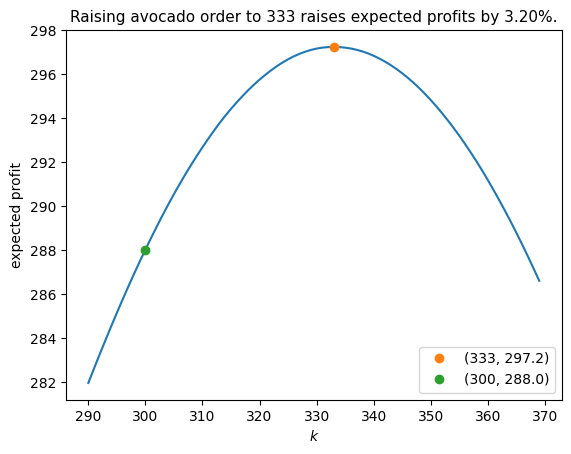

Optimal order quantity: 333
Expected profit at optimal k: 297.25
Expected profit at k=300: 288.04
Percent increase in expected profit: 3.20%


In [16]:
unit_cost = 1.0
unit_revenue = 2.0

demand = rng.normal(m_bar[-1], s_bar[-1], size=(10_000, 1))
ks = np.arange(290, 370)
exp_sales = np.array([np.mean(np.minimum(demand, k)) for k in ks])
exp_profit = (unit_revenue - unit_cost) * exp_sales - unit_cost * (ks - exp_sales)
opt_idx = np.argmax(exp_profit)
opt_k = ks[opt_idx]
opt_exp_profit = exp_profit[opt_idx]
exp_profit_300 = exp_profit[ks == 300][0]
exp_profit_percent_change = 100 * (opt_exp_profit - exp_profit_300) / exp_profit_300

plt.plot(ks, exp_profit)
plt.plot(
    opt_k,
    opt_exp_profit,
    "o",
    label=f"({opt_k}, {opt_exp_profit.round(1)})",
)
plt.plot(300, exp_profit_300, "o", label=f"(300, {exp_profit_300.round(1)})")
plt.xlabel("$k$")
plt.ylabel("expected profit")
plt.legend(loc="lower right")
plt.title(
    f"Raising avocado order to {opt_k} raises expected profits by {exp_profit_percent_change:.2f}%.",
    fontsize=11,
)
plt.show()

print(f"Optimal order quantity: {opt_k}")
print(f"Expected profit at optimal k: {opt_exp_profit:.2f}")
print(f"Expected profit at k=300: {exp_profit_300:.2f}")
print(f"Percent increase in expected profit: {exp_profit_percent_change:.2f}%")

## Incorporating price-elasticity of demand

Your other cousin Avi owns another gourmet fruit and vegetable store and wants your help optimizing his avocado (or, as she calls them, Avicado) sales.
He gets a shipment of 300 avocados at the beginning of every week, and sells out about half the time.
He doesn't carry over Avicado stock week-to-week. 

Avi wants your help "data science-ing" her sales records from the last two years to better estimate Evacado demand, with an eye to optimizing his weekly order.
Here's a sketch of how you might proceed:

Avicado prices and demand both fluctuate week-to-week.
Let $p_i$ be the avocado price for week $i$ (known) and let $y_i$ be the Avicado demand (unknown if Avi sells out).
Model the expected Avicado demand $\mu(p)=\mathbb{E}[y_i\mid p_i]=\mu(p)$ at price $p$  as a linear function of $p$:
$$
\mu(p_i) = \alpha + \beta p_i
$$
Model $y_i$ as a normally distributed random variable with mean $\mu_i$ and homoskedastic standard deviation $\sigma$:
$$
y_i\sim N(\alpha + \beta p_i, \sigma^2)
$$
In this exercise, we develop an approach to estimating $\alpha$ and $\beta$, and $\sigma$.

Let $x_i$ be the number of Avicados sold in week $i$; this is our dataset.
Note that $x_i\leq 300$.
If $x_i \lt 300$, then $y_i=x_i`. If, on the other hand, $x_i=300$, then we don't know what $y_i$ is.

Given initial estimates $a$, $b$, and $s$ of $\alpha$, $\beta$, and $\sigma$, we can guess at (jargon: **impute**) the true Evacado demand $y_i$ for week $i$.
If $x_i < 300$, set $Y_i=x_i$.
If, on the other hand, $x_i \geq 300$, draw samples from $N(a + b p_i, s^2)$ until we get one that's $\geq 300$; call it $Y_i$.

Now use the imputed demands $Y_i$ to update your estimates of $\alpha$, $\beta$, and $\sigma$ by fitting a linear regression of $Y$ on $p$.

We've designed a mechanism that takes, as input, a triple $(a, b, s)$ and produces, as output, a hopefully improved version $(a', b', s')$.
We can iterate this process, hopefully converging on good estimates of $\alpha$, $\beta$ and $\sigma$.
Kick the process off by initializing $Y$ to $x$.


**Your task:**
Implement this scheme for estimating $\beta_0$, $\beta`, and $\sigma$.

- Start by computing vectors `a`, `b`, and `s` of length `n_iter` (2000) containing your sequence of estimates of $\beta_0$, $\beta$, and $\sigma`, and plotting them.
(I provided the plotting code below.)

- You should notice that `a` and `b`, and `s` are noisy.
Smooth them out by averaging.
Specifically, compute vectors `a_bar`, `b_bar`, and `s_bar` of length `n_iter` whose `i`-th enties are the averages of `a[:i + 1]` and `b[:i + 1]`, and `s[:i + 1]`.
Plot these, too; again, I provided the plotting code.

- Your final estimates of $\beta_0$, $\beta$, and $\sigma$ are `a_bar[-1]`, `b_bar[-1]`, and `s_bar[-1]`.

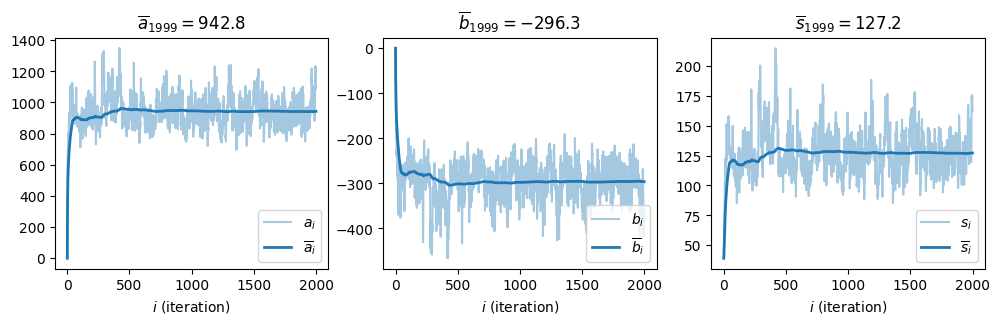

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error  # How might this be useful?


k = 300  # weekly Evacado supply
n_iter = 2000
rng = np.random.default_rng(42)

# fmt: off
p =  np.array([2.04, 1.96, 2.19, 2.03, 1.84, 2.11, 2.39, 2.28, 1.79, 1.62, 1.81,
                   2.01, 1.3 , 1.93, 1.63, 1.78, 1.84, 1.91, 2.12, 2.31, 1.96, 2.41,
                   1.8 , 2.11, 2.27, 2.03, 1.78, 1.72, 1.86, 2.07, 1.7 , 1.94, 1.95,
                   2.16, 2.06, 2.11, 1.8 , 1.96, 2.24, 2.45, 1.62, 2.45, 2.4 , 2.23,
                   2.08, 1.91, 2.44, 2.59, 2.54, 2.39, 2.11, 1.64, 2.  , 2.2 , 1.61,
                   2.12, 2.13, 2.21, 1.64, 1.8 , 1.87, 1.65, 2.52, 1.85, 2.1 , 1.92,
                   2.48, 2.4 , 2.19, 1.34, 2.02, 2.21, 2.3 , 1.81, 2.55, 1.6 , 1.8 ,
                   2.28, 2.01, 2.6 , 2.06, 1.81, 1.89, 1.67, 1.62, 2.19, 2.17, 2.39,
                   1.77, 2.51, 1.91, 2.47, 1.87, 1.78, 2.07, 2.31, 2.05, 1.82, 1.6 ,
                   1.58, 2.15, 2.3 , 1.95, 1.68])

x = np.array([300, 254, 242, 300, 233, 298, 218, 262, 300, 300, 300, 268, 300,
                   300, 300, 300, 300, 300, 285, 196, 300, 207, 273, 293, 236, 254,
                   291, 300, 300, 300, 300, 300, 300, 300, 196, 300, 300, 300, 278,
                   247, 300, 218, 163, 261, 255, 300, 222, 214, 185, 221, 283, 294,
                   300, 265, 300, 186, 300, 256, 300, 300, 300, 300, 225, 263, 300,
                   300, 270, 241, 300, 300, 300, 262, 196, 300, 140, 300, 300, 216,
                   300, 201, 273, 300, 297, 300, 300, 252, 196, 189, 300, 221, 300,
                   295, 268, 300, 270, 276, 265, 300, 295, 300, 300, 235, 300, 296])
# fmt: on


def sample_from_truncated_normal(m, s):
    """Draw len(x) samples from the normal distribution with mean `m` and
    standard deviation `s` conditioned on those samples being >= k."""
    a, b = (k - m) / s, np.inf
    return stats.truncnorm.rvs(a, b, loc=m, scale=s, size=(x == k).sum(), random_state=rng)

# Initialize arrays to store the sequence of estimates
a = np.zeros(n_iter)
b = np.zeros(n_iter)
s = np.zeros(n_iter)
model = LinearRegression()

# Initial imputation: set Y = x
Y = x.copy().astype(float)

# Initial estimates
a[0] = 0
b[0] = 0
s[0] = Y.std()

for i in range(1, n_iter):
    # Impute censored values
    Y_imp = Y.copy()
    mask = (x == k)
    if mask.any():
        Y_imp[mask] = sample_from_truncated_normal(a[i-1] + b[i-1] * p[mask], s[i-1])
    # Update estimates
    model.fit(p.reshape(-1, 1), Y_imp)
    a[i] = model.intercept_
    b[i] = model.coef_[0]
    s[i] = Y_imp.std()
    Y = Y_imp

# Compute running averages
a_bar = np.cumsum(a) / (np.arange(n_iter) + 1)
b_bar = np.cumsum(b) / (np.arange(n_iter) + 1)
s_bar = np.cumsum(s) / (np.arange(n_iter) + 1)


fig, [a_ax, b_ax, s_ax] = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex=True)
a_ax.plot(a, alpha=0.4, label="$a_{i}$")
a_ax.plot(
    a_bar,
    "C0",
    lw=2,
    label="$\\overline{a}_{i}$",
)
a_ax.set_xlabel("$i$ (iteration)")
a_ax.legend(loc="lower right")
a_ax.set_title(f"$\\overline{{a}}_{{ {n_iter - 1} }} = {a_bar[-1].round(1)}$")

b_ax.plot(b, alpha=0.4, label="$b_{i}$")
b_ax.plot(
    b_bar,
    "C0",
    lw=2,
    label="$\\overline{b}_{i}$",
)
b_ax.set_xlabel("$i$ (iteration)")
b_ax.legend(loc="lower right")
b_ax.set_title(f"$\\overline{{b}}_{{ {n_iter - 1} }} = {b_bar[-1].round(1)}$")

s_ax.plot(s, alpha=0.4, label="$s_i$")
s_ax.plot(
    s_bar,
    "C0",
    lw=2,
    label="$\\overline{s}_{i}$",
)
s_ax.set_xlabel("$i$ (iteration)")
s_ax.legend()
s_ax.set_title(f"$\\overline{{s}}_{{{n_iter - 1} }} = {s_bar[-1].round(1)}$")

plt.show()

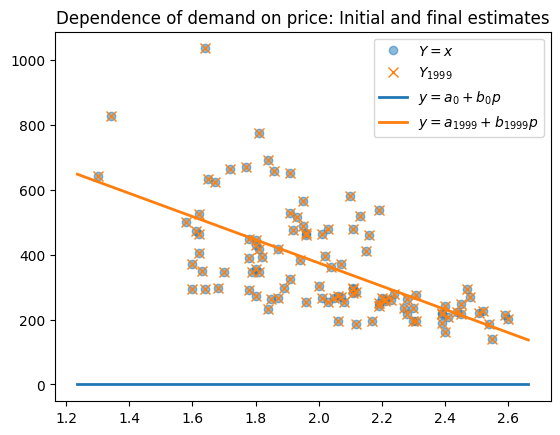

In [18]:
plt.plot(p, Y, "o", alpha=0.5, label="$Y=x$")
plt.plot(p, Y_imp, "x", ms=7, alpha=1, label=f"$Y_{{ {n_iter - 1} }}$")
t = np.linspace(*plt.xlim())
plt.plot(t, a[0] + b[0] * t, "C0", lw=2, label="$y = a_0 + b_0 p$")
plt.plot(
    t,
    a[-1] + b[-1] * t,
    "C1",
    lw=2,
    label=f"$y = a_{{ {n_iter - 1} }} + b_{{ {n_iter - 1} }} p$",
)
plt.legend()
plt.title("Dependence of demand on price: Initial and final estimates")
plt.show()

## Optimizing Avi's avocado order

Suppose Avi always sells an Avicado for twice what he paid for it.

1. For each week $i$, how many Avocados should Avi have ordered for $p_i/2$ dollars and sold for $p_i$ dollars to maximize his excpected profits, according to your model? Do this by simulation, as in Eva's case.

2. By how what percentage would you expect his profits to have increased by following this strategy instead of simply ordering 300 avocados every week?

Average optimal order quantity: 310.6
Average expected profit (optimized): 225.01
Average expected profit (order 300): 209.07
Percent increase in expected profit: 7.62%


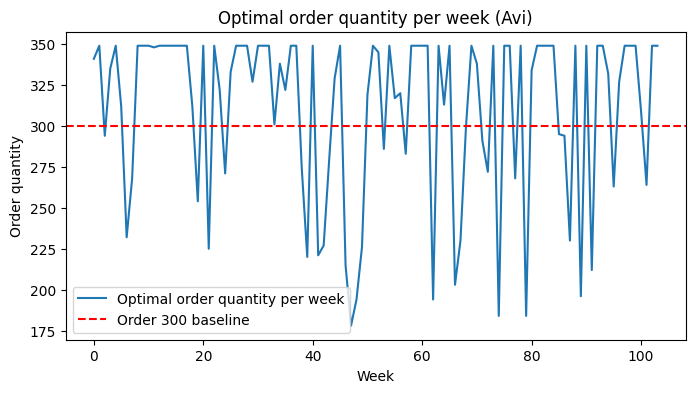

In [19]:
# Simulate optimal order for Avi (price-elastic demand)
unit_costs = p / 2
unit_revenues = p
n_weeks = len(p)
ks = np.arange(150, 350)

# Simulate demand for each week using the final estimated linear model
mu = a_bar[-1] + b_bar[-1] * p
# Broadcast mu to shape (n_weeks, 1000) for sampling
mu_broadcast = np.repeat(mu[:, np.newaxis], 1000, axis=1)
sim_demand = rng.normal(mu_broadcast, s_bar[-1])  # shape: (weeks, sims)

# For each week, find k that maximizes expected profit
best_ks = np.zeros(n_weeks, dtype=int)
best_profits = np.zeros(n_weeks)
profits_300 = np.zeros(n_weeks)

for i in range(n_weeks):
    week_profits = []
    for k in ks:
        sales = np.minimum(sim_demand[i], k)
        exp_sales = np.mean(sales)
        exp_profit = (unit_revenues[i] - unit_costs[i]) * exp_sales - unit_costs[i] * (k - exp_sales)
        week_profits.append(exp_profit)
    week_profits = np.array(week_profits)
    best_idx = np.argmax(week_profits)
    best_ks[i] = ks[best_idx]
    best_profits[i] = week_profits[best_idx]
    # Baseline: always order 300
    sales_300 = np.minimum(sim_demand[i], 300)
    exp_sales_300 = np.mean(sales_300)
    profits_300[i] = (unit_revenues[i] - unit_costs[i]) * exp_sales_300 - unit_costs[i] * (300 - exp_sales_300)

mean_best_profit = np.mean(best_profits)
mean_profit_300 = np.mean(profits_300)
percent_increase = 100 * (mean_best_profit - mean_profit_300) / mean_profit_300

print(f"Average optimal order quantity: {np.mean(best_ks):.1f}")
print(f"Average expected profit (optimized): {mean_best_profit:.2f}")
print(f"Average expected profit (order 300): {mean_profit_300:.2f}")
print(f"Percent increase in expected profit: {percent_increase:.2f}%")

plt.figure(figsize=(8, 4))
plt.plot(best_ks, label='Optimal order quantity per week')
plt.axhline(300, color='r', linestyle='--', label='Order 300 baseline')
plt.xlabel('Week')
plt.ylabel('Order quantity')
plt.title('Optimal order quantity per week (Avi)')
plt.legend()
plt.show()
